Precision and recall are standard metrics for evaluating the performance of binary classifiers. Proper model tuning requires an understanding of the tradeoff that exists between them as well as the best way to balance it for the problem at hand. In this post, I detail the ways of extending these metrics to the multi-label multi-class case, and I work through an example from a recent project to examine the tradeoff.

### Binary Classification

In binary classification, each point is assumed to belong to one of two classes (positive or negative). The true positive count (TP), false positive count (FP), and false negative count (FN) form the building blocks for calculating precision and recall. True positives occur when the true and predicted classes are positve, false positives occur when the true class is negative and the predicted class is positive, and finally false negatives occur when the true class is positive and the predicted class is negative. Precision and recall are then as follows.

<center>
$$
\begin{align}
Precision =&& \frac{TP}{TP + FP} \\
Recall =&& \frac{TP}{TP + FN}
\end{align}
$$
</center>

Any model can achieve perfect recall by predicting positive for all points because the false negative count would be zero, but this comes at the expense of a high false positive count and lower precision. Similarly, high precision (but not necessarily perfect) comes at the expense of more false negatives and lower recall by predicting positive only when confidence is very high. These extremes illustrate the tradeoff between the two metrics. Because both are oftentimes not useful without knowledge of the other, their harmonic mean, called F1, is sometimes used. Choosing a proper metric to evaluate a classifier is highly dependent on the application. 

<center>
$$F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$$
</center>

As an example, consider the problem of predicting whether a patient has a life threatening disease. Precision is the rate at which positive diagnoses are correct, and recall is the proportion of diseased patients who we correctly diagnose. In this oft-cited example, the tradeoff is significant. A false negative (saying someone is healthy when they actually have the disease) means a patient could miss out on life saving treatment. A false positive (saying someone has the disease when they don't) could cause unnecessary treatment that has adverse affects and temporary trauma. The cost of false negative here is likely higher, but doctors/researchers must decide how to ethically balance the tradeoff between precision and recall.

### Generalizing to the Multi-Label Problem

Consider the multi-label multi-class problem where there are $N$ distinct classes, labeled $\{0, ..., N-1\}$ for simplicity, and each point can be assigned anywhere between 0 and $N$ distinct labels. Precision, recall, and F1 generalize to this case by reducing the problem to several binary ones. Let's say we have a classifier that emits a label set $y_i \subseteq \{0, ..., N-1\}$ for the $i$th point. We can decompose this classifier into $N$ binary ones where for each class $i$, the predicted label for a point is positive if its label set contains $i$ and negative otherwise. Scikit-learn implements three methods for combining the results of these $N$ classifiers to get generalized precision, recall, and F1 scores:

* **micro**: Sum the $N$ TP, FP, and FN counts produced by the classifiers and use the resulting global TP, FP, and FN counts to get precision and recall values. Calculate F1 from the global precision and recall.
* **macro**: Calculate precision, recall, and F1 for each of the $N$ binary classifiers and average to get the global values.
* **weighted**: Same as **macro** except instead of a simple average, take the average weighted by the number of true instances for each label.

### An Example

I recently worked on a multi-label classification problem for an online competition (see [here](https://github.com/llefebure/indeed-ml) for the full project) which involved assigning a variable number of tags to free-form text job descriptions. These tags included things like "Bachelor's Degree Required" and "2-4 Years Experience Needed". One of the models I considered was a "one-vs-rest" logistic regression, where I constructed a binary logistic regression for each of the 12 classes independently using as features a vector model for correlated unigrams, bigrams, and trigrams.

Logistic regression produces class probability estimates, and by default, it predicts positive when this estimate is greater than one half and negative otherwise. Adjusting that threshold is a simple way of tuning the balance between precision and recall. For example, lowering it to .3 would result in a classifier that has higher recall because it predicts positive more often.

In [8]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.metrics import f1_score, precision_score, recall_score
%matplotlib inline

In [9]:
with open("./data/logistic_regression_predictions.dat", "rb") as f:
    y_pred = pickle.load(f) # probability predictions from logistic regression, 1313x12
with open("./data/logistic_regression_true.dat", "rb") as f:
    y_true = pickle.load(f) # true labels (0/1), 1313x12

The plot below shows the precision, recall, and F1 scores against the threshold for a held out validation set in the job description tagging problem. I calculated the metrics according to the "micro" strategy described above. As the threshold increases, the model makes fewer positive predictions. This results in more false negatives (lower recall) and fewer false positives (higher precision). The default threshold of one half produces a classifier with a significant imbalance between precision and recall. This is not inherently bad, however I settled on using a threshold around .3 because submissions in the competition were judged according to F1.

In [10]:
grid_result = list()
for i in np.divide(range(100), 100.):
    row = [
        i, # threshold value
        1.*(y_pred > i).sum()/y_pred.shape[0], # avg. tags per prediction
        precision_score(y_true, y_pred > i, average = "micro"),
        recall_score(y_true, y_pred > i, average = "micro"),
        f1_score(y_true, y_pred > i, average = "micro")
    ]
    grid_result.append(row)
grid_result = np.array(grid_result)

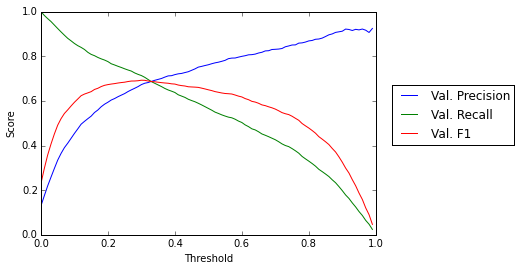

In [11]:
plt.plot(grid_result[:,0], grid_result[:,2:5])
plt.legend(["Val. Precision", "Val. Recall", "Val. F1"], bbox_to_anchor=(1.43, .7))
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.show()

A closer look at the numbers shows another important consideration in the multi-label case. The threshold value used is inversely related to the average number of tags per prediction. In the training set, there were 1.58 tags per label on average, and the table below shows that the threshold value that produces maximal F1 score also lines up closely with this value.

In [12]:
grid_result_pretty = pd.DataFrame(grid_result)
grid_result_pretty.columns = ["Threshold", "Avg. Tags Per Prediction", "Val. Precision", "Val. Recall", "Val. F1"]
display(grid_result_pretty[29:34])

,Threshold,Avg. Tags Per Prediction,Val. Precision,Val. Recall,Val. F1
29,0.29,1.686215,0.663957,0.718826,0.690303
30,0.30,1.651181,0.672970,0.713447,0.692618
31,0.31,1.618431,0.679059,0.705623,0.692086
32,0.32,1.588728,0.682167,0.695844,0.688937
33,0.33,1.554455,0.687408,0.686064,0.686735


For my purposes, optimizing for F1 was the goal. However, this may not be the case for Indeed. Accurately tagging job descriptions adds business value by helping Indeed, jobseekers, and employers. Indeed would get more organized content, jobseekers would more easily filter and find content, and employers would source more candidates because their content would be easier to find. There are several ways to achieve this, each requiring a model with a different balance between precision and recall.

Imagine a service on the job search site where tags are suggested to employers when they post jobs. The employer could then click on the relevant ones to add the metadata to their job posting. For such a service, they would likely want to err on the side of predicting too many tags, or in other words, they would want to weight recall higher than precision. This is because the employer would easily be able to click on relevant recommended tags and ignore extras when posting a job, but if a relevant tag was missing from the recommended list, they may not know the tag exists or make the effort to search through the database to find it.

Alternatively (or perhaps complementarily), this could be used as a way for Indeed to automatically tag already posted job descriptions that are missing metadata. For this application, they would likely want to weight precision higher than recall, the opposite of the recommendation service suggested above. This is because the tags that are assigned should be as accurate as possible since jobseekers will interact with them directly when searching and browsing jobs. Irrelevant tags would make Indeed and/or the jobseeker look bad, so the cost of leaving out a relevant tag is probably less than that of adding an irrelevant one.

This example sheds light on how these metrics connect to a real world use case. While the task is clearly defined, what constitues a "good" model is highly dependent on the context in which it is deployed. I've learned (and am still learning!) that keeping in mind business objectives and understanding the why is important to building practical machine learning models.